## PCB Images Training & Testing

### 1. Load the relevant libraries

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
print(tf.__version__)

2.10.0


### 2. Load training set

In [46]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    validation_split = 0.1,
    subset = "training",
    batch_size = 32,
    seed=123,
    image_size=(110, 42),
    shuffle=True)

Found 12000 files belonging to 8 classes.
Using 10800 files for training.


### 3. Perform sanity checks

In [47]:
class_names = training_set.class_names
print(class_names)
data_iterator = training_set.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape)
batch[1]

['0', '1', '2', '3', '4', '5', '6', '7']
(32, 110, 42, 3)


array([0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 4, 3, 0, 1, 0, 1, 0, 0, 4])

### 4. Plot some images

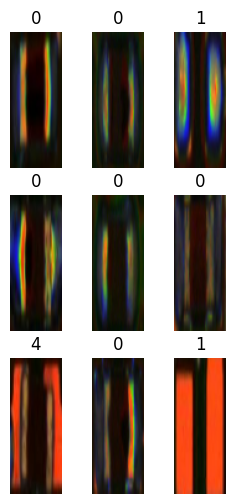

In [48]:
plt.figure(figsize=(3, 6))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 5. Standardize data

In [49]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.8446448


In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)

### 6. DEFINE the model

In [71]:
num_classes = 8
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (110, 42, 3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [72]:
model.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

In [73]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    validation_split = 0.1,
    subset = "validation",
    batch_size = 32,
    seed=123,
    image_size=(110, 42),
    shuffle=True)

Found 12000 files belonging to 8 classes.
Using 1200 files for validation.


### 8. Fit the model

In [74]:
history = model.fit(
  training_set,
  validation_data = val_set,
  epochs = 5
)

Epoch 1/5
338/338 [==============================] - 29s 85ms/step - loss: 0.4242 - accuracy: 0.8644 - val_loss: 0.2203 - val_accuracy: 0.9325
Epoch 2/5
338/338 [==============================] - 29s 86ms/step - loss: 0.1817 - accuracy: 0.9423 - val_loss: 0.1360 - val_accuracy: 0.9575
Epoch 3/5
338/338 [==============================] - 29s 84ms/step - loss: 0.1293 - accuracy: 0.9587 - val_loss: 0.1155 - val_accuracy: 0.9667
Epoch 4/5
338/338 [==============================] - 29s 86ms/step - loss: 0.1033 - accuracy: 0.9662 - val_loss: 0.1341 - val_accuracy: 0.9558
Epoch 5/5
338/338 [==============================] - 29s 86ms/step - loss: 0.0856 - accuracy: 0.9732 - val_loss: 0.1381 - val_accuracy: 0.9517


In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 110, 42, 3)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 40, 16)       448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 54, 20, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 18, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 9, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 7, 64)        

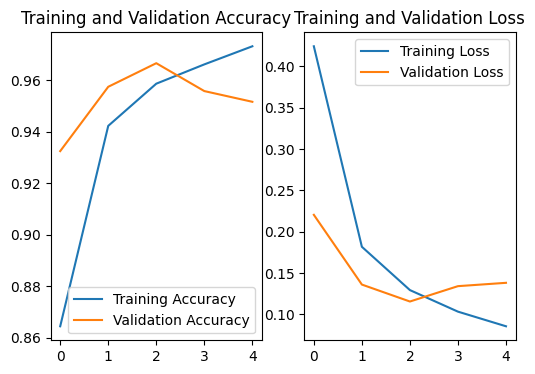

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Predict from Evaluation Data

In [78]:
import matplotlib.image as pmg

In [80]:
test_path = "D:/data/PCB/Evaluation_Dataset"
image_names = []
class_name_pred = []
pred_prob = []
for filename in os.listdir(test_path):
    img = pmg.imread(os.path.join(test_path, filename))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #Create batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    image_names.append(filename)
    #print("This image belongs to class {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))
    class_name_pred.append(class_names[np.argmax(score)])
    pred_prob.append(100*np.max(score))

1/1 [==============================] - 0s 32ms/step


### 10. Write output to Text file

In [81]:
with open('class_output.txt', 'w') as f:    
    f.write("Image Name  ---- Class ----- Prob")
    f.write('\n')
    for val in range(len(class_name_pred)):
        f.write(str(image_names[val]) + "-----" + str(class_name_pred[val]) + "-----" + str(pred_prob[val]))
        f.write('\n')
    

In [79]:
test_path_image1 = "D:/data/PCB/Evaluation_Dataset/20200224212137_R365_1.png"
img = pmg.imread(test_path_image1)
h, w, c = img.shape
img.shape = w, h, c
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print("This image belongs to class {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

1/1 [==============================] - 0s 122ms/step
tf.Tensor(
[2.2787426e-01 1.2530577e-04 5.1262919e-03 6.0248530e-01 2.5022859e-03
 7.2234623e-02 1.3403944e-02 7.6248012e-02], shape=(8,), dtype=float32)
This image belongs to class 3 with a 60.25 percent confidence
